In [4]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
#django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Minimalistic exploration for handling *Binomial* models


In [5]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import itertools as it
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


### Summon the raster container
#### Import raster container

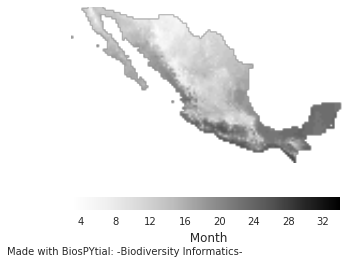

In [6]:

from raster_api.tools import RasterContainer
from raster_api.models import ETOPO1,MeanTemperature
from raster_api.tools import RasterData
from sketches.models import Country
from mesh.models import MexMesh
Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)
elevation = RasterData(rastermodelinstance=MeanTemperature,border=Mexico.geom)
#Rescale to fit same number of pixels
pixel_size = 0.25
elevation.rescale(pixel_size)
elevation.display_field(origin='Lower')

## Read the data stored

In [21]:
#datatrain = pd.read_csv("/outputs/sample_data.csv")
datatrain = pd.read_csv("/outputs/reptiles_train.csv")
datatrain.columns


Index([u'Unnamed: 0', u'Y', u'Elevation_mean', u'MaxTemperature_mean',
       u'MeanTemperature_mean', u'MinTemperature_mean', u'Precipitation_mean',
       u'SolarRadiation_mean', u'Vapor_mean', u'WindSpeed_mean', u'Longitude',
       u'Latitude'],
      dtype='object')

In [22]:
datapred = pd.read_csv('/outputs/sample_predictors.csv')
datapred.columns


Index([u'Unnamed: 0', u'SolarRadiation', u'Elevation', u'MinTemperature',
       u'MaxTemperature', u'WindSpeed', u'MeanTemperature', u'Vapor',
       u'Precipitation', u'Longitude', u'Latitude'],
      dtype='object')

In [23]:
datacube_clean = datapred.dropna()



In [24]:
## Convert to geopandas
from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')



In [56]:
datafull = datatrain.replace('N.A.',np.nan).astype('float')


In [51]:
import statsmodels.api as sm
from statsmodels.formula.api import OLS
from statsmodels.genmod.generalized_linear_model import GLM
# change name

glmodel = GLM.from_formula('Y ~ Elevation_mean + MeanTemperature_mean ',data=datafull,family=sm.families.Binomial(sm.families.links.logit))
#glmodel = OLS.from_formula('bats_rich ~ WindSpeed_mean',data=datafull)
#glmodel = OLS(ndatafull.bats_rich.values,ndatafull.WindSpeed_mean.values)
res = glmodel.fit()
print(res.summary())


z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])

PerfectSeparationError: Perfect separation detected, results not available

In [13]:
z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])
print(coefs)



NameError: name 'res' is not defined

In [193]:
from pymc3.variational.callbacks import CheckParametersConvergence
with pm.Model() as model:
    #sigma = 1.0
    #range_a=10.13
    #tau = pm.Uniform('tau',0,50)
    tau = pm.HalfNormal('tau',sd=10)
    #sigma = pm.Uniform('sigma',0,10)
    sigma = pm.HalfNormal('sigma',sd=10)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    Tau = pm.gp.cov.Constant(tau)
    cov = (sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1])) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)
    ## Parameters for linear predictor
    b0 = pm.Normal('b0',mu=0,sd=10)
    b = pm.Normal('b',mu=6,sd=10,shape=2)
    mf = pm.gp.mean.Linear(coeffs=[b],intercept=b0) 
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    

    f = gp.prior("latent_field", X=datafull[['Longitude','Latitude','Elevation_mean','MaxTemperature_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Bernoulli('y_obs',logit_p=f,observed=datafull[['Y']].values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    #%time f_star = gp.conditional("f_star", data_star.iloc[:,1:3].values)
    #%time f_star = gp.conditional("f_star", small_sample.iloc[:,1:3].values)
    %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','Elevation','MeanTemperature']].values)
    ## Full data
    ##%time f_star = gp.conditional("f_star",elev_data.iloc[:,1:3].values)


    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=100)

   

Average Loss = 1.3887e+05: 100%|██████████| 15000/15000 [32:30<00:00,  7.69it/s]
Finished [100%]: Average Loss = 1.3887e+05
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 1.3887e+05


CPU times: user 1h 42min 1s, sys: 26min 36s, total: 2h 8min 37s
Wall time: 32min 32s
CPU times: user 1.6 s, sys: 24 ms, total: 1.63 s
Wall time: 1.57 s


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 2.82 s, sys: 1.03 s, total: 3.85 s
Wall time: 1.72 s


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


In [194]:
preds = pd.DataFrame(pred_samples['f_star']).transpose()



In [222]:
mean_sample = preds.mean(axis=1)
q_025 = preds.quantile(0.025,axis=1)
q_975 = preds.quantile(0.975,axis=1)
surface_data = pd.DataFrame({'mean_sample' : mean_sample, 'q_025':q_025,'q_975':q_975})

In [223]:
#preds['idx'] = data_star.index.values
surface_data['idx'] = datacube_clean.index.values


In [224]:
predictions = datapred.merge(surface_data,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

In [225]:
predicted_data = predictions.mean_sample.values

### Using the Raster Container

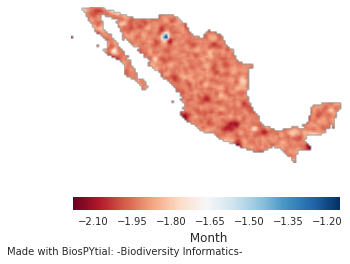

In [226]:
mean_presences_of_something = RasterContainer(predicted_data,use_metadata_from=elevation.rasterdata)
mean_presences_of_something.display_field(band=1,origin='Lower',cmap=plt.cm.RdBu)

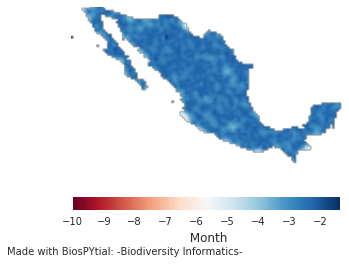

In [227]:
ql_presences_of_something = RasterContainer(predictions.q_025.values,use_metadata_from=elevation.rasterdata)
ql_presences_of_something.display_field(band=1,origin='Lower',cmap=plt.cm.RdBu)

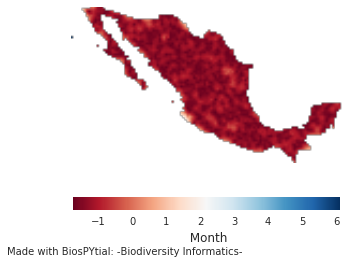

In [228]:
qh_presences_of_something = RasterContainer(predictions.q_975.values,use_metadata_from=elevation.rasterdata)
qh_presences_of_something.display_field(band=1,origin='Lower',cmap=plt.cm.RdBu)

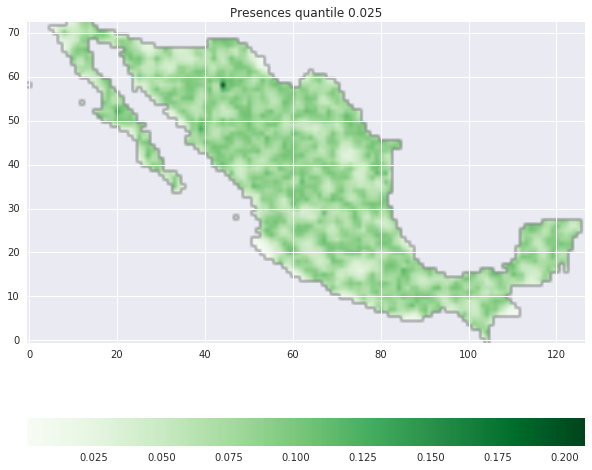

In [230]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
expit(ql_presences_of_something.rasterdata.bands[0].data())
plt.imshow(expit(ql_presences_of_something.rasterdata.bands[0].data()),origin='Lower',cmap=plt.cm.Greens)
plt.title("Presences quantile 0.025")
plt.colorbar(orientation='horizontal')

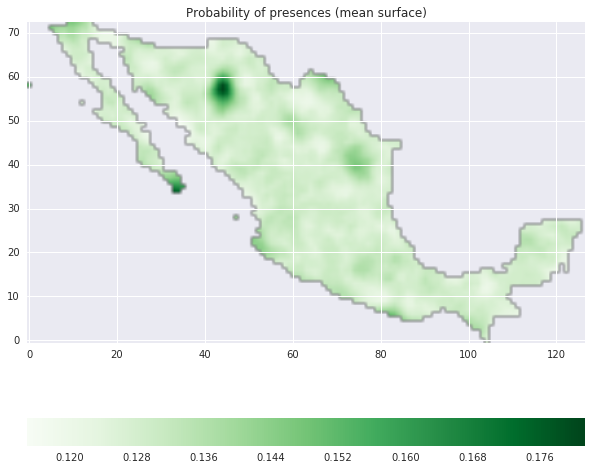

In [231]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(expit(presences_of_something.rasterdata.bands[0].data()),origin='Lower',cmap=plt.cm.Greens)

plt.colorbar(orientation='horizontal')
plt.title('Probability of presences (mean surface)' )

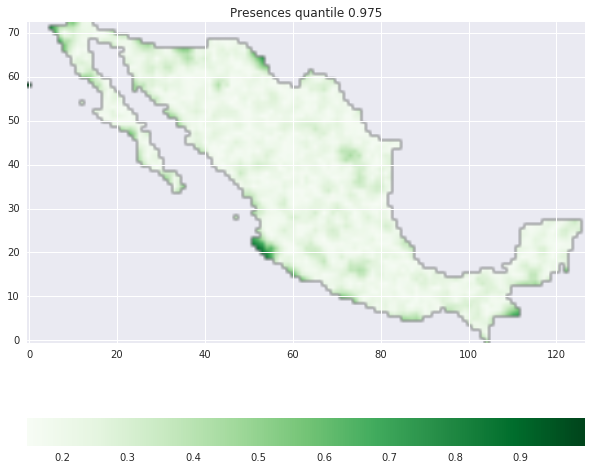

In [233]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(expit(qh_presences_of_something.rasterdata.bands[0].data()),origin='Lower',cmap=plt.cm.Greens)
plt.colorbar(orientation='horizontal')
plt.title("Presences quantile 0.975")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9374c1450>,
      dtype=object)

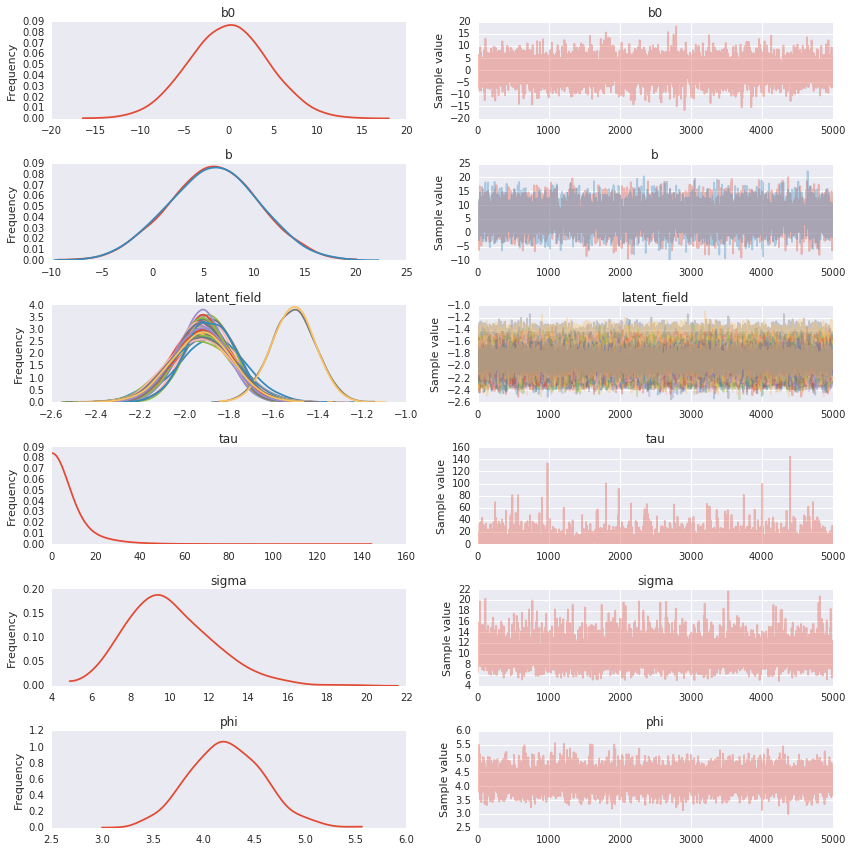

In [150]:
pm.traceplot(trace)

/opt/conda/envs/biospytial/lib/python2.7/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/opt/conda/envs/biospytial/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/opt/conda/envs/biospytial/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


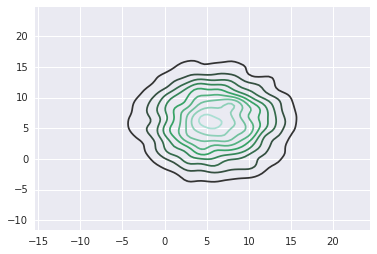

In [67]:
sns.kdeplot(trace['b'])

<MultiTrace: 1 chains, 5000 iterations, 9 variables>